In [1]:
import xarray as xr
from xmitgcm import open_mdsdataset
import xgcm
import numpy as np
import warnings
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfiltfilt
import matplotlib.animation as animation
from fastjmd95 import rho
import sys
warnings.filterwarnings("ignore")

dsState = xr.open_dataset('~/TPOSE6_Daily_2012.nc',engine='netcdf4')
dsState = dsState.assign_coords(lon = (dsState.lon-220)*111.3)

In [2]:

sigma_0 = (rho(dsState.SALT, dsState.THETA, 0)-1000)

# TIW filter
fs = 1/86400
highF = (1/15)*fs # equivalent to 15 days per cycle
lowF = (1/40)*fs
order = 4
cutoff = [lowF, highF]
sos = butter(order, cutoff, 'bandpass', fs=fs, output='sos')


In [3]:
dTdx = (dsState.THETA[:,:,1:,:].values - dsState.THETA[:,:,:-1,:].values)/(1/6)

tmp = dsState.THETA[:,:,:-1,:].copy(deep=True)
tmp.values = dTdx
tmp.name = 'dTdx'
dTdx = tmp 

dTdx_filt = sosfiltfilt(sos, dTdx, axis=3)
tmp = dsState.THETA[:,:,:-1,:].copy(deep=True)
tmp.values = dTdx_filt
tmp.name = 'dTdx_filt'
dTdx_filt = tmp 

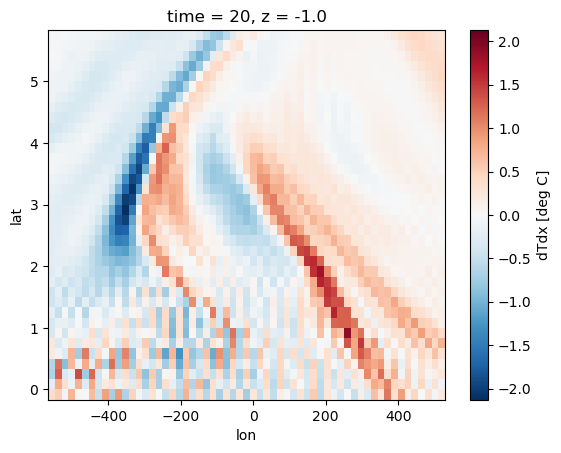

In [4]:
dTdx.sel(time=[20.0],method='nearest').isel(z=0).plot()

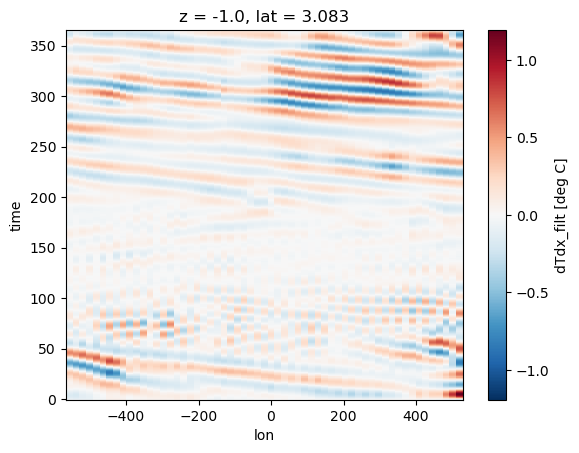

In [5]:
dTdx_filt.sel(lat=[3.0],method='nearest').isel(z=0).T.plot()

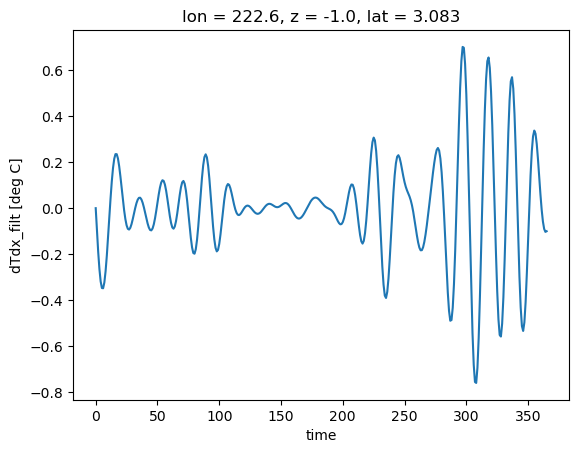

In [6]:
dTdx_filt.sel(lat=[3.0],lon=[220.0],method='nearest').isel(z=0).T.plot()

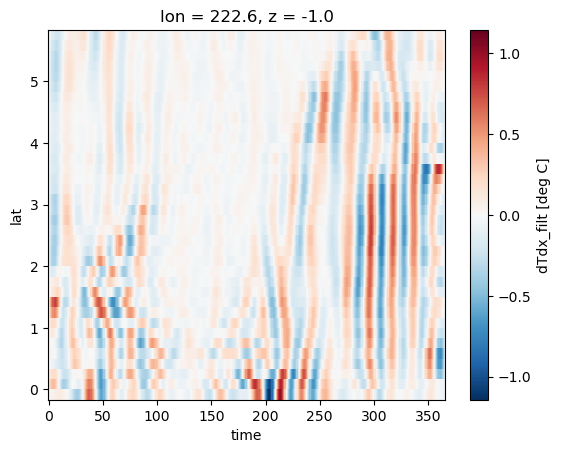

In [7]:
dTdx_filt.sel(lon=[220.0],method='nearest').isel(z=0).plot()

In [8]:
# print('barotropic flow') # depth average
barotropic_w = dsState.WVEL.mean(dim='z')
baroclinic_w = dsState.WVEL - barotropic_w
# TIW filter
fs = 1/86400
lowF = (1/15)*fs # equivalent to 15 days per cycle
order = 4
cutoff = [lowF, highF]
sos = butter(order, lowF, 'highpass', fs=fs, output='sos')
baroclinic_w_filt = sosfiltfilt(sos, baroclinic_w.values, axis=1)

tmp = dsState.WVEL.copy(deep=True)
tmp.values = baroclinic_w_filt
tmp.name = 'baroclinic_w_filt'
baroclinic_w_filt = tmp 

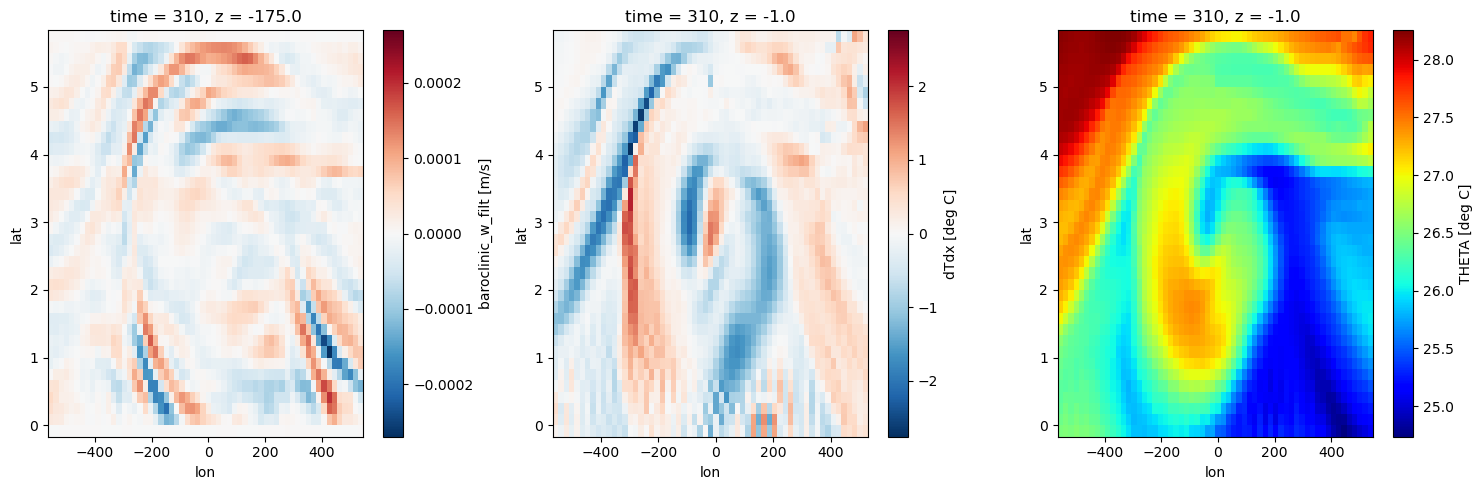

In [9]:
fig, ax = plt.subplots(figsize=(15,5),ncols=3)
baroclinic_w_filt.sel(time=[310.0],z=[-180.0],method='nearest').plot(ax=ax[0])
dTdx.sel(time=[310.0],z=[0.0],method='nearest').plot(ax=ax[1])
dsState.THETA.sel(time=[310.0],z=[0.0],method='nearest').plot(ax=ax[2],cmap='jet')
plt.tight_layout()

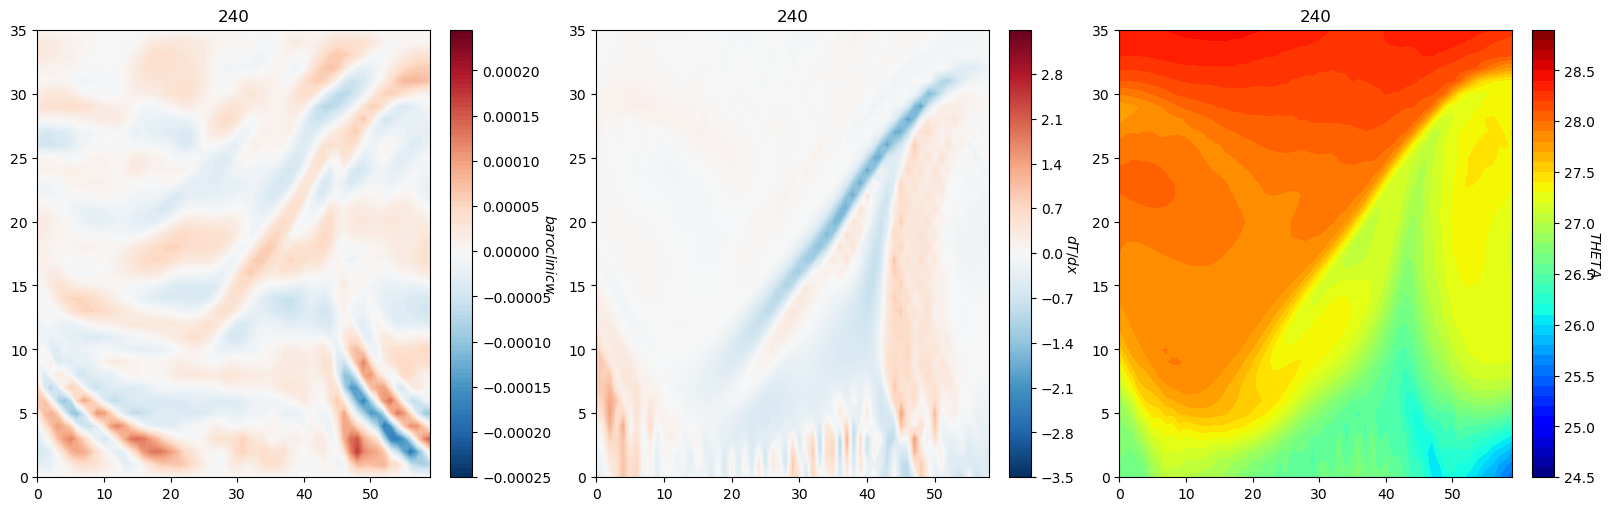

In [36]:
fig, ax = plt.subplots(figsize=(16,5),ncols=3,constrained_layout=True)
pos1 = ax[0].contourf(baroclinic_w_filt.sel(time=0,z=[-180.0],method='nearest').squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
ax[0].set_xlabel('Lon')
ax[0].set_ylabel('Lat')
cbar1 = fig.colorbar(pos1,ax=ax[0])
cbar1.set_label('$baroclinic w$', rotation=270)

# add contours of phi
pos2 = ax[1].contourf(dTdx.sel(time=0,z=[0.0],method='nearest').squeeze(),cmap='RdBu_r',levels=np.arange(-3.5,3.5,0.01))
ax[1].set_xlabel('Lon')
ax[1].set_ylabel('Lat')
cbar2 = fig.colorbar(pos2,ax=ax[1])
cbar2.set_label('$dT/dx$', rotation=270)

# add wind vectors and vertical shear contours
pos3 = ax[2].contourf(dsState.THETA.sel(time=0,z=[0.0],method='nearest').squeeze(),cmap='jet',levels=np.arange(24.5,29,0.1))
ax[2].set_xlabel('Lon')
ax[2].set_ylabel('Lat')
cbar3 = fig.colorbar(pos3,ax=ax[2])
cbar3.set_label('$THETA$', rotation=270)

startDay = 240

def update(frame):

    day = frame + startDay 
    ax[0].clear()
    pos1 = ax[0].contourf(baroclinic_w_filt.sel(time=day,z=[-180.0],method='nearest').squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
    # pos1.set_data(data)
    ax[0].set_title(str(day))

    ax[1].clear()
    pos2 = ax[1].contourf(dTdx.sel(time=day,z=[0.0],method='nearest').squeeze(),cmap='RdBu_r',levels=np.arange(-3.5,3.5,0.01))
    # pos2.set_data(data)
    ax[1].set_title(str(day))

    ax[2].clear()
    pos3 = ax[2].contourf(dsState.THETA.sel(time=day,z=[0.0],method='nearest').squeeze(),cmap='jet',levels=np.arange(24.5,29,0.1))
    # pos3.set_data(data)
    ax[2].set_title(str(day))

    return (pos1,pos2,pos3)

video = animation.FuncAnimation(fig=fig, func=update, frames=len(range(240,366)),interval=250)
videostr = "Tiw_animation.mp4"
# video.save(filename=videostr, writer="ffmpeg")

In [10]:
dudz = (dsState.UVEL[1:,:,:,:].values - dsState.UVEL[:-1,:,:,:].values)/(dsState.z[1:].values[:,np.newaxis,np.newaxis,np.newaxis]-dsState.z[:-1].values[:,np.newaxis,np.newaxis,np.newaxis])
dvdz = (dsState.VVEL[1:,:,:,:].values - dsState.VVEL[:-1,:,:,:].values)/(dsState.z[1:].values[:,np.newaxis,np.newaxis,np.newaxis]-dsState.z[:-1].values[:,np.newaxis,np.newaxis,np.newaxis])

tmp = dsState.UVEL[:-1,:,:,:].copy(deep=True)
tmp.values = dudz
tmp.name = 'dudz'
dudz = tmp 

tmp = dsState.VVEL[:-1,:,:,:].copy(deep=True)
tmp.values = dvdz
tmp.name = 'dvdz'
dvdz = tmp 

shear_2 = dudz**2 + dvdz**2



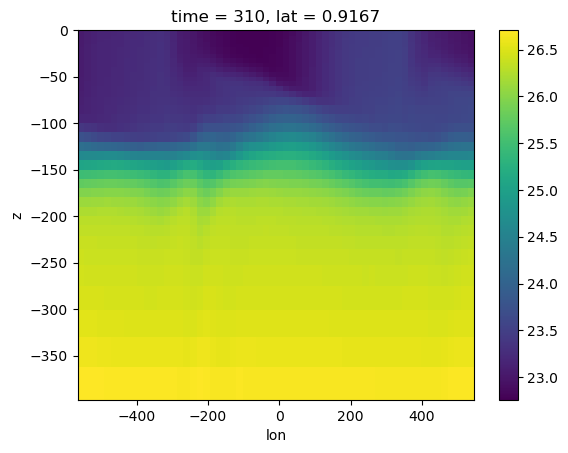

In [11]:
sigma_0.sel(time=[310.0],lat=[1.0],method='nearest').sel(z=slice(0,-400)).plot()

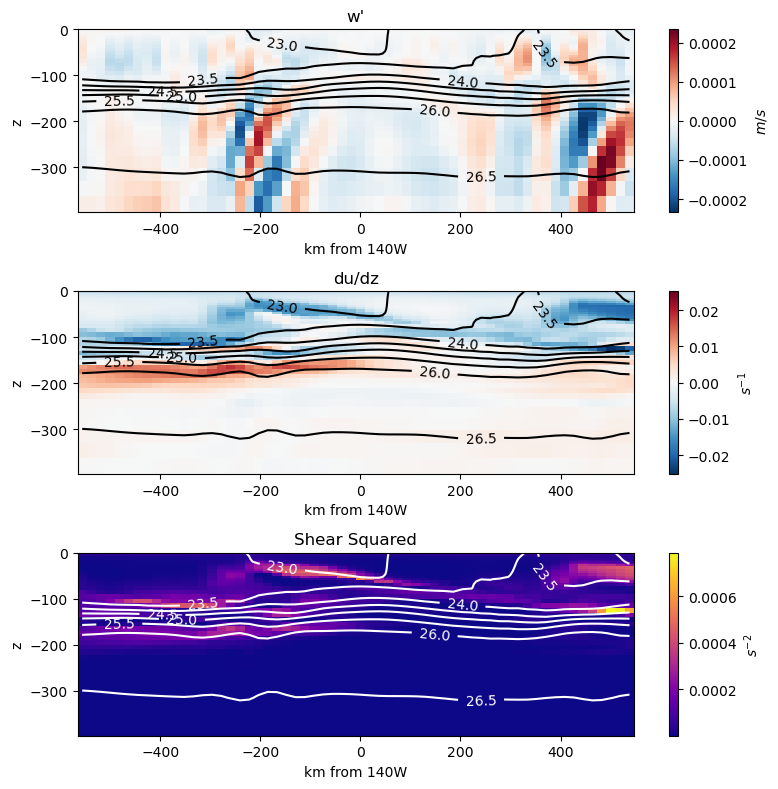

In [15]:
sigma_plot = sigma_0.sel(time=[310.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()

fig, ax = plt.subplots(figsize=(8,8),nrows=3)
baroclinic_w_filt.sel(time=[310.0],lat=[1.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[0],cmap='RdBu_r',cbar_kwargs={'label':'$m/s$'})
CS = sigma_plot.plot.contour(ax=ax[0],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(CS)
ax[0].set_title('w\'')
ax[0].set_xlabel('km from 140W')

dudz.sel(time=[310.0],lat=[1.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[1],cmap='RdBu_r',cbar_kwargs={'label':'$s^{-1}$'})
CS = sigma_plot.plot.contour(ax=ax[1],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(CS)
ax[1].set_title('du/dz')
ax[1].set_xlabel('km from 140W')

shear_2.sel(time=[310.0],lat=[1.0],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[2],cmap='plasma',cbar_kwargs={'label':'$s^{-2}$'})
CS  = sigma_plot.plot.contour(ax=ax[2],levels=np.arange(23.0,28.5,0.5),colors='w',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(CS)
ax[2].set_title('Shear Squared')
ax[2].set_xlabel('km from 140W')


plt.tight_layout()

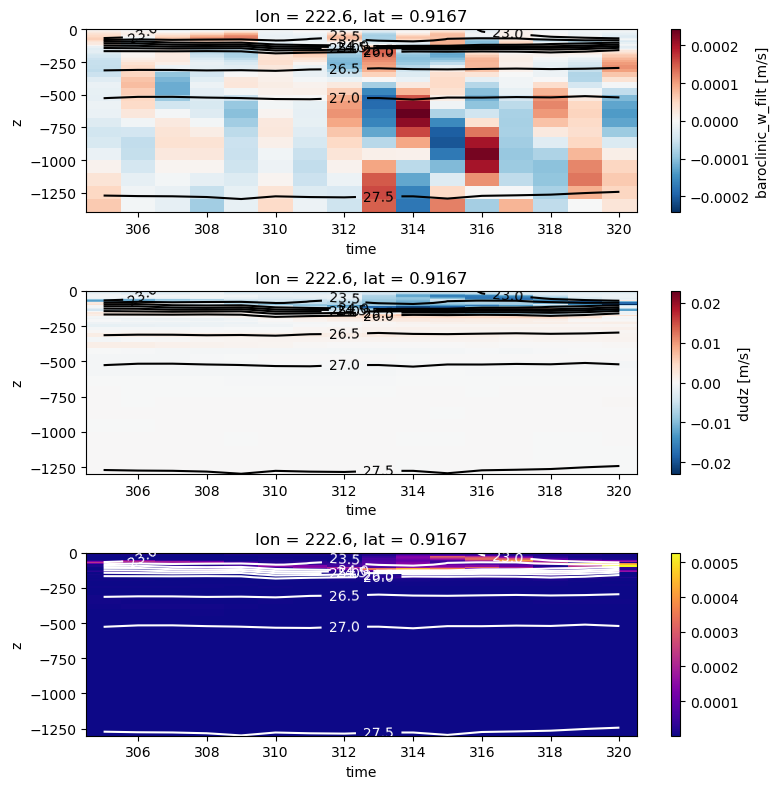

In [16]:
sigma_plot = sigma_0.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,320)).squeeze()

fig, ax = plt.subplots(figsize=(8,8),nrows=3)
baroclinic_w_filt.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,320)).plot(ax=ax[0],cmap='RdBu_r')
ax[0].set_title('w\'')
CS = sigma_plot.plot.contour(ax=ax[0],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(CS)

dudz.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,320)).plot(ax=ax[1],cmap='RdBu_r')
ax[1].set_title('du/dz')
CS = sigma_plot.plot.contour(ax=ax[1],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(CS)

shear_2.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,320)).plot(ax=ax[2],cmap='plasma')
ax[2].set_title('Shear Squared')
CS  = sigma_plot.plot.contour(ax=ax[2],levels=np.arange(23.0,28.5,0.5),colors='w',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(CS)

plt.tight_layout()

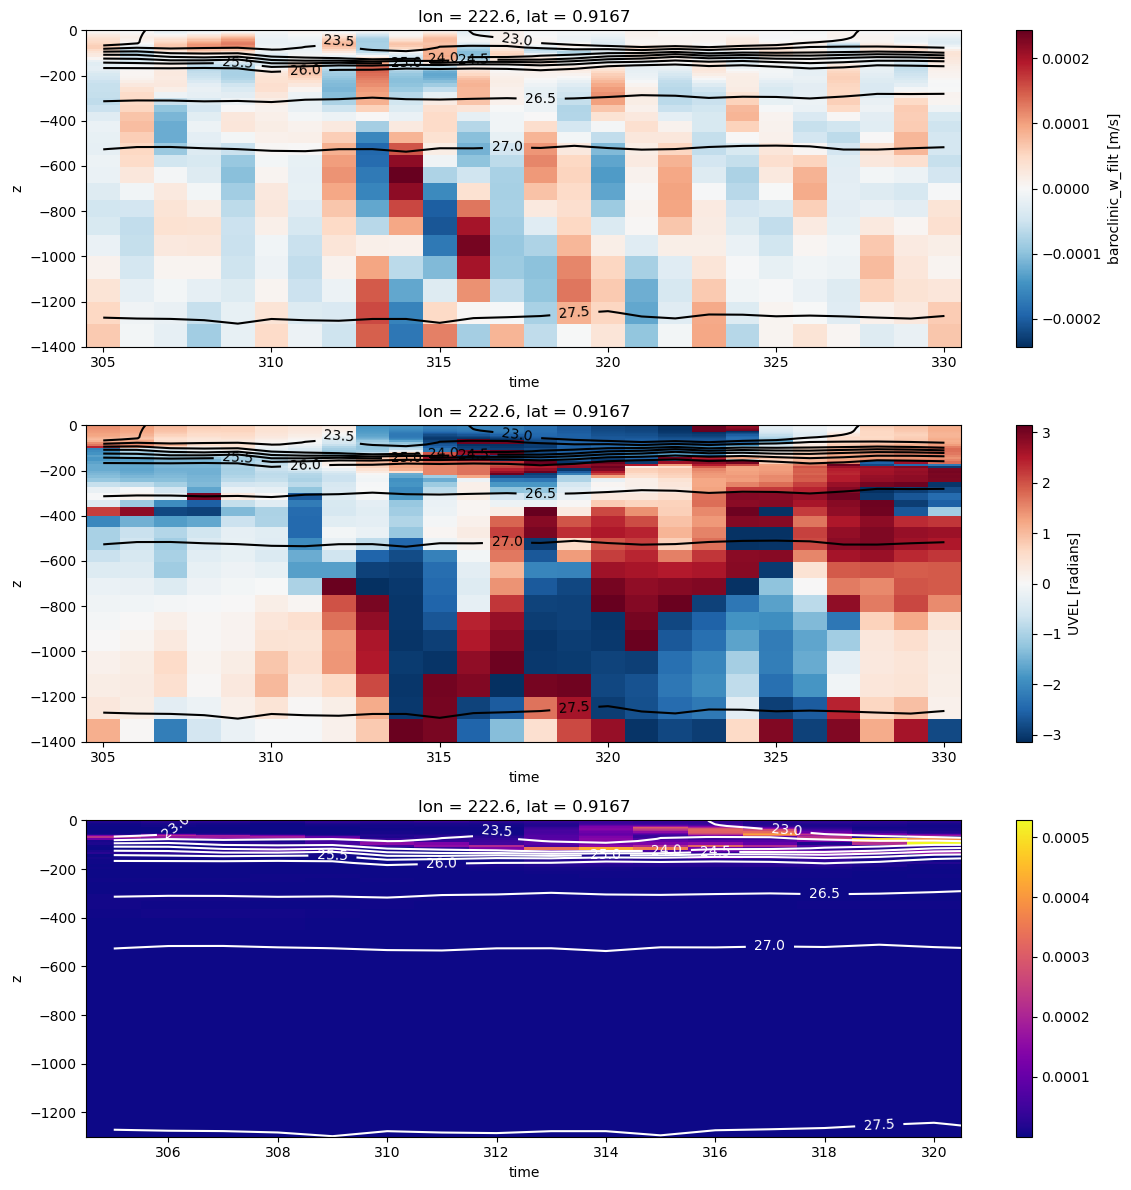

In [19]:
sigma_plot = sigma_0.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,330)).squeeze()
v_prof = dsState.VVEL.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,330)).mean('time')
v_anom = dsState.VVEL.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,330)) - v_prof
u_prof = dsState.UVEL.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,330)).mean('time')
u_anom = dsState.UVEL.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,330)) - u_prof

angle = np.arctan2(u_anom,v_anom)
angle.attrs['units'] = 'radians'
angle.attrs['name'] = 'angle'

fig, ax = plt.subplots(figsize=(12,12),nrows=3)
baroclinic_w_filt.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,330)).plot(ax=ax[0],cmap='RdBu_r')
ax[0].set_title('w\'')
CS = sigma_plot.plot.contour(ax=ax[0],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(CS)

angle.plot(ax=ax[1],cmap='RdBu_r')
ax[1].set_title('du/dz')
CS = sigma_plot.plot.contour(ax=ax[1],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(CS)

shear_2.sel(lat=[1.0],lon=[220.0],method='nearest').sel(time=slice(305,320)).plot(ax=ax[2],cmap='plasma')
ax[2].set_title('Shear Squared')
CS  = sigma_plot.plot.contour(ax=ax[2],levels=np.arange(23.0,28.5,0.5),colors='w',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(CS)

plt.tight_layout()

Text(0.5, 0, 'km from 140W')

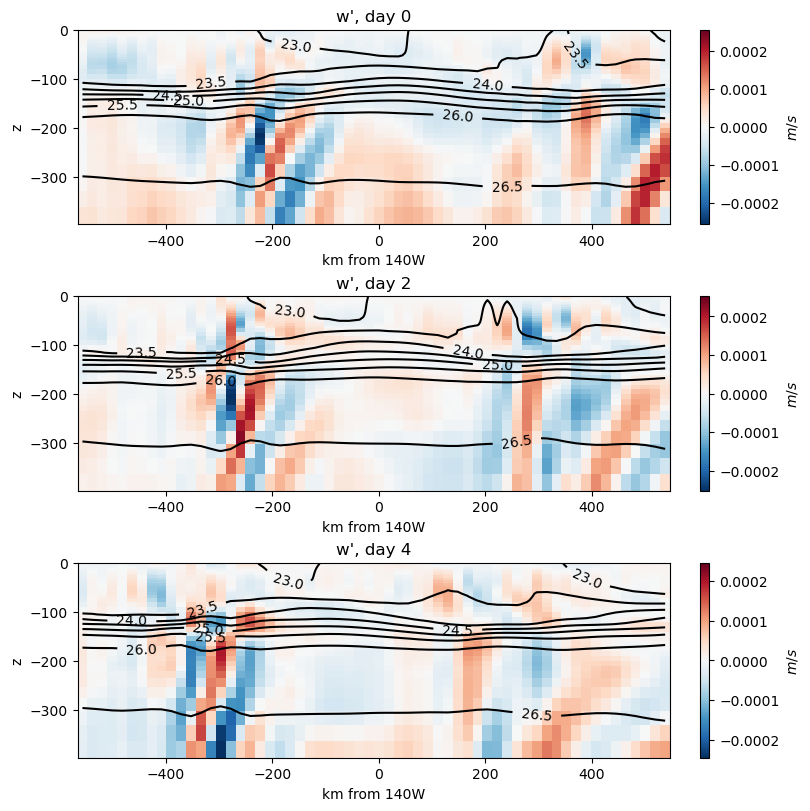

In [21]:
fig, ax = plt.subplots(figsize=(8,8),nrows=3,constrained_layout=True)
baroclinic_w_filt.sel(time=[310.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[0],cmap='RdBu_r',cbar_kwargs={'label':'$m/s$'})
sigma_plot = sigma_0.sel(time=[310.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
CS = sigma_plot.plot.contour(ax=ax[0],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(CS)
theta_plot = dsState.THETA.sel(time=[310.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
# TS = theta_plot.plot.contour(ax=ax[0],levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
# ax[0].clabel(TS)
# ax[0].axvline(-200,color='m')
ax[0].set_title('w\', day 0')
ax[0].set_xlabel('km from 140W')

baroclinic_w_filt.sel(time=[312.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[1],cmap='RdBu_r',cbar_kwargs={'label':'$m/s$'})
sigma_plot = sigma_0.sel(time=[312.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
CS = sigma_plot.plot.contour(ax=ax[1],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
theta_plot = dsState.THETA.sel(time=[312.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
# TS = theta_plot.plot.contour(ax=ax[1],levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
# ax[1].clabel(TS)
ax[1].clabel(CS)
# ax[1].axvline(-200,color='m')
ax[1].set_title('w\', day 2')
ax[1].set_xlabel('km from 140W')

baroclinic_w_filt.sel(time=[314.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[2],cmap='RdBu_r',cbar_kwargs={'label':'$m/s$'})
sigma_plot = sigma_0.sel(time=[314.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
CS  = sigma_plot.plot.contour(ax=ax[2],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(CS)
theta_plot = dsState.THETA.sel(time=[314.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
# TS = theta_plot.plot.contour(ax=ax[2],levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
# ax[2].clabel(TS)
# ax[2].axvline(-200,color='m')
ax[2].set_title('w\', day 4')
ax[2].set_xlabel('km from 140W')

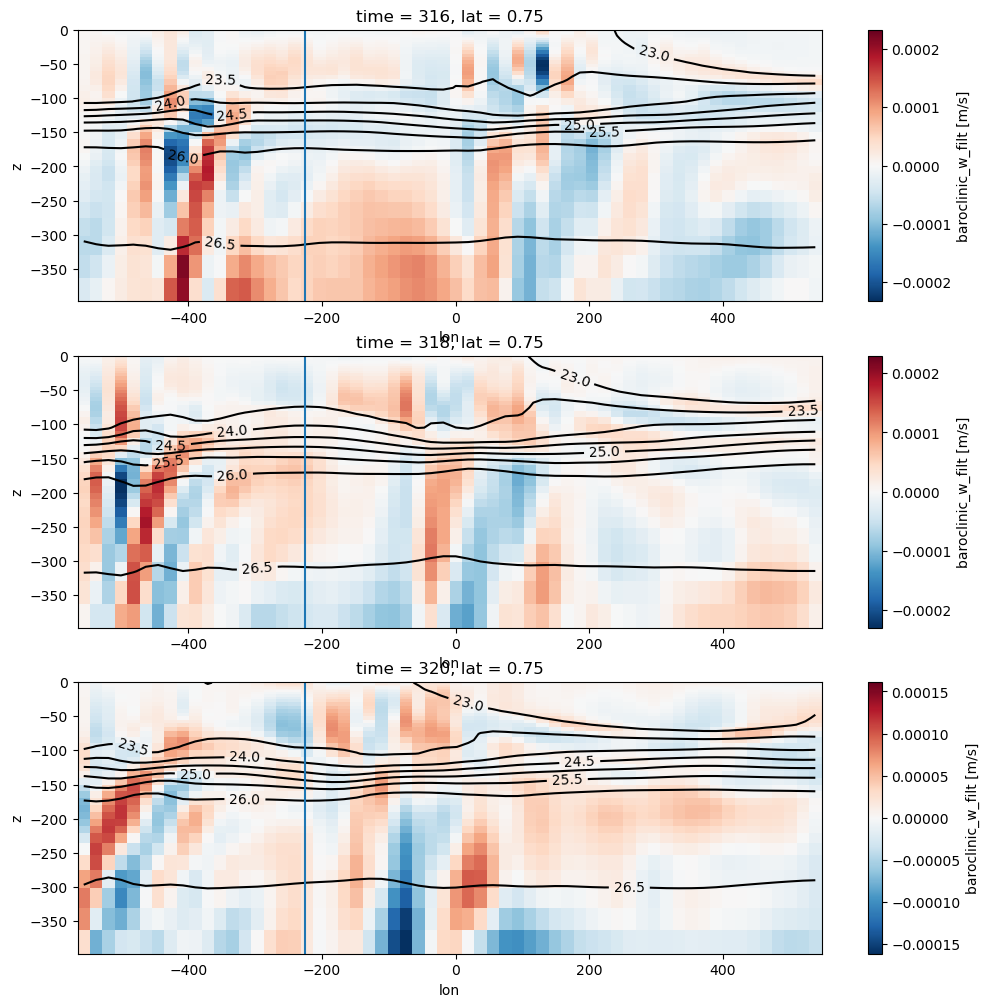

In [24]:
fig, ax = plt.subplots(figsize=(12,12),nrows=3)
baroclinic_w_filt.sel(time=[316.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[0],cmap='RdBu_r')
ax[0].set_title('w\'')
sigma_plot = sigma_0.sel(time=[316.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
CS = sigma_plot.plot.contour(ax=ax[0],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(CS)
ax[0].axvline(-225)

baroclinic_w_filt.sel(time=[318.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[1],cmap='RdBu_r')
ax[1].set_title('du/dz')
sigma_plot = sigma_0.sel(time=[318.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
CS = sigma_plot.plot.contour(ax=ax[1],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(CS)
ax[1].axvline(-225)

baroclinic_w_filt.sel(time=[320.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).plot(ax=ax[2],cmap='RdBu_r')
ax[2].set_title('Shear Squared')
sigma_plot = sigma_0.sel(time=[320.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
CS  = sigma_plot.plot.contour(ax=ax[2],levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(CS)
ax[2].axvline(-225)

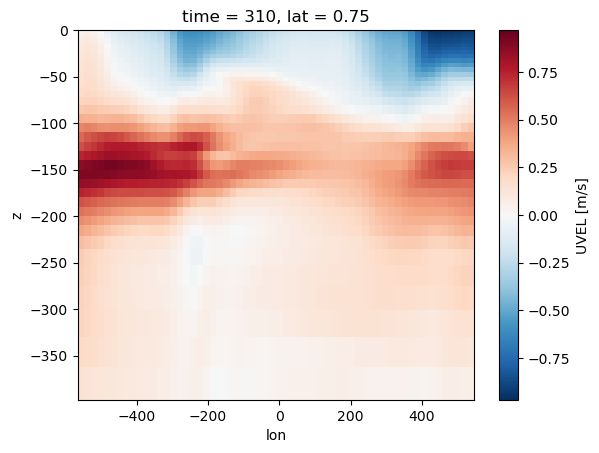

In [29]:
dsState.UVEL.sel(time=[310.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).plot()

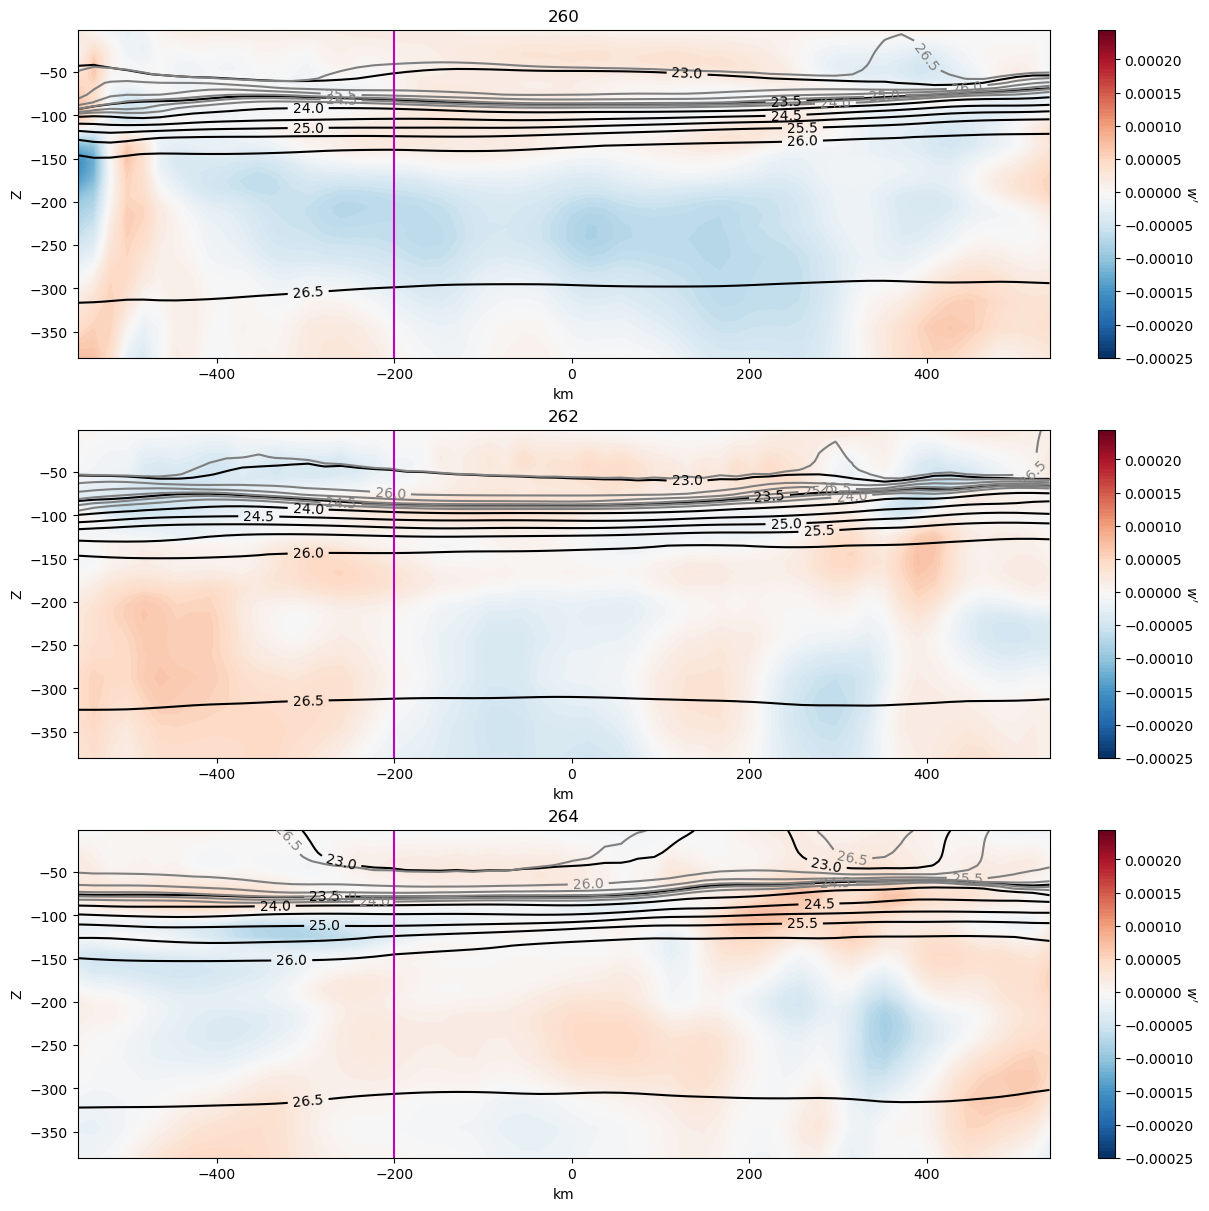

In [63]:
fig, ax = plt.subplots(figsize=(12,12),nrows=3,constrained_layout=True)
xax = dsState.lon.values
yax = dsState.z.sel(z=slice(0,-400)).values

pos1 = ax[0].contourf(xax,yax,baroclinic_w_filt.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
ax[0].set_xlabel('km')
ax[0].set_ylabel('Z')
cbar1 = fig.colorbar(pos1,ax=ax[0])
cbar1.set_label('$w\'$', rotation=270)
sigma_plot1 = sigma_0.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
SL1 = ax[0].contour(xax,yax,sigma_plot1,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(SL1)
theta_plot1 = dsState.THETA.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
TL1 = ax[0].contour(xax,yax,theta_plot1,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(TL1)
# ax[0].axvline(-200,color='m')

# add contours of phi
pos2 = ax[1].contourf(xax,yax,baroclinic_w_filt.sel(time=[262.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
ax[1].set_xlabel('km')
ax[1].set_ylabel('Z')
cbar2 = fig.colorbar(pos1,ax=ax[1])
cbar2.set_label('$w\'$', rotation=270)
sigma_plot2 = sigma_0.sel(time=[262.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
SL2 = ax[1].contour(xax,yax,sigma_plot2,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(SL2)
theta_plot2 = dsState.THETA.sel(time=[262.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
TL2 = ax[1].contour(xax,yax,theta_plot2,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(TL2)
# ax[1].axvline(-200,color='m')

# add wind vectors and vertical shear contours
pos3 = ax[2].contourf(xax,yax,baroclinic_w_filt.sel(time=[264.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
ax[2].set_xlabel('km')
ax[2].set_ylabel('Z')
cbar3 = fig.colorbar(pos1,ax=ax[2])
cbar3.set_label('$w\'$', rotation=270)
sigma_plot3 = sigma_0.sel(time=[264.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
SL3 = ax[2].contour(xax,yax,sigma_plot3,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(SL3)
theta_plot3 = dsState.THETA.sel(time=[264.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
TL3 = ax[2].contour(xax,yax,sigma_plot3,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(TL3)
# ax[2].axvline(-200,color='m')

startDay = 260

def update(frame):

    day = frame + startDay

    ax[0].clear()
    pos1 = ax[0].contourf(xax,yax,baroclinic_w_filt.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
    sigma_plot1 = sigma_0.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
    SL1 = ax[0].contour(xax,yax,sigma_plot1,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
    ax[0].clabel(SL1)
    ax[0].set_xlabel('km')
    ax[0].set_ylabel('Z')
    theta_plot1 = dsState.THETA.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
    TL1 = ax[0].contour(xax,yax,theta_plot1,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
    ax[0].clabel(TL1)
    ax[0].axvline(-200,color='m')    
    ax[0].set_title(str(day))


    ax[1].clear()
    pos2 = ax[1].contourf(xax,yax,baroclinic_w_filt.sel(time=[day+2],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
    sigma_plot2 = sigma_0.sel(time=[day+2],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
    SL2 = ax[1].contour(xax,yax,sigma_plot2,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
    ax[1].clabel(SL2)
    ax[1].set_xlabel('km')
    ax[1].set_ylabel('Z')
    theta_plot2 = dsState.THETA.sel(time=[day+2],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
    TL2 = ax[1].contour(xax,yax,theta_plot2,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
    ax[1].clabel(TL2)
    ax[1].axvline(-200,color='m')
    ax[1].set_title(str(day+2))

    ax[2].clear()
    pos3 = ax[2].contourf(xax,yax,baroclinic_w_filt.sel(time=[day+4],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
    sigma_plot3 = sigma_0.sel(time=[day+4],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
    SL3 = ax[2].contour(xax,yax,sigma_plot3,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
    ax[2].clabel(SL3)
    ax[2].set_xlabel('km')
    ax[2].set_ylabel('Z')
    theta_plot3 = dsState.THETA.sel(time=[day+4],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
    TL3 = ax[2].contour(xax,yax,theta_plot3,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
    ax[2].clabel(TL3)
    ax[2].axvline(-200,color='m')    
    ax[2].set_title(str(day+4))


    return (pos1,pos2,pos3)

video = animation.FuncAnimation(fig=fig, func=update, frames=len(range(280,366)),interval=500)
videostr = "Leewave_isopycnal_animation.mp4"
video.save(filename=videostr, writer="ffmpeg")

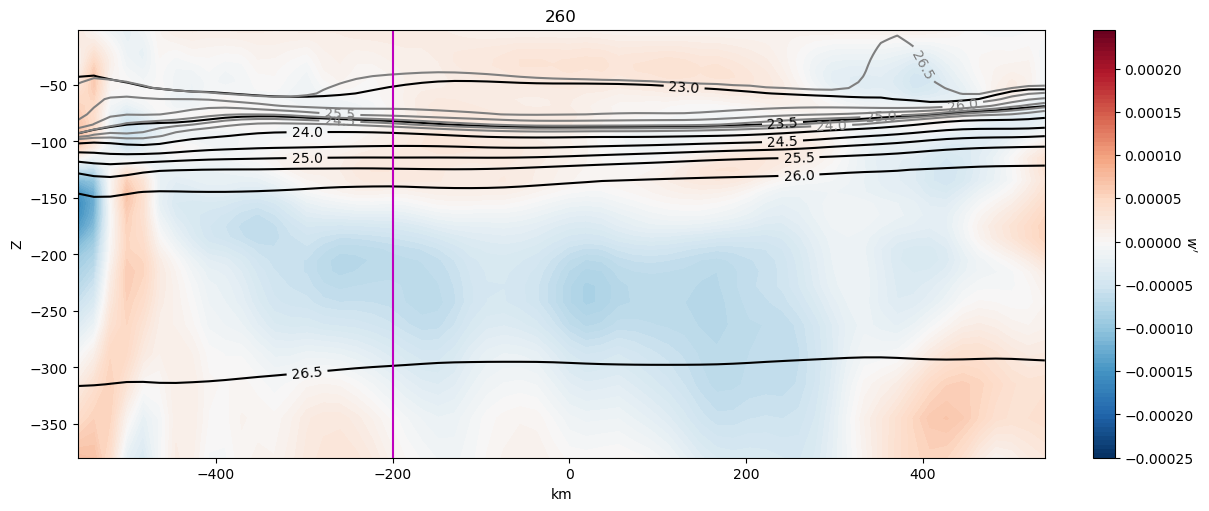

In [65]:
fig, ax = plt.subplots(figsize=(12,5),constrained_layout=True)
xax = dsState.lon.values
yax = dsState.z.sel(z=slice(0,-400)).values

pos1 = ax.contourf(xax,yax,baroclinic_w_filt.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
ax.set_xlabel('km')
ax.set_ylabel('Z')
cbar1 = fig.colorbar(pos1,ax=ax)
cbar1.set_label('$w\'$', rotation=270)
sigma_plot1 = sigma_0.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
SL1 = ax.contour(xax,yax,sigma_plot1,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax.clabel(SL1)
theta_plot1 = dsState.THETA.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
TL1 = ax.contour(xax,yax,theta_plot1,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
ax.clabel(TL1)

startDay = 260

def update(frame):

    day = frame + startDay

    ax.clear()
    pos1 = ax.contourf(xax,yax,baroclinic_w_filt.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
    sigma_plot1 = sigma_0.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
    SL1 = ax.contour(xax,yax,sigma_plot1,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
    ax.clabel(SL1)
    ax.set_xlabel('km')
    ax.set_ylabel('Z')
    theta_plot1 = dsState.THETA.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,-400)).squeeze()
    TL1 = ax.contour(xax,yax,theta_plot1,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
    ax.clabel(TL1)
    ax.axvline(-200,color='m')    
    ax.set_title(str(day))

    return (pos1)

video = animation.FuncAnimation(fig=fig, func=update, frames=len(range(280,366)),interval=500)
videostr = "Leewave_isopycnal_animation_1panel.mp4"
video.save(filename=videostr, writer="ffmpeg")

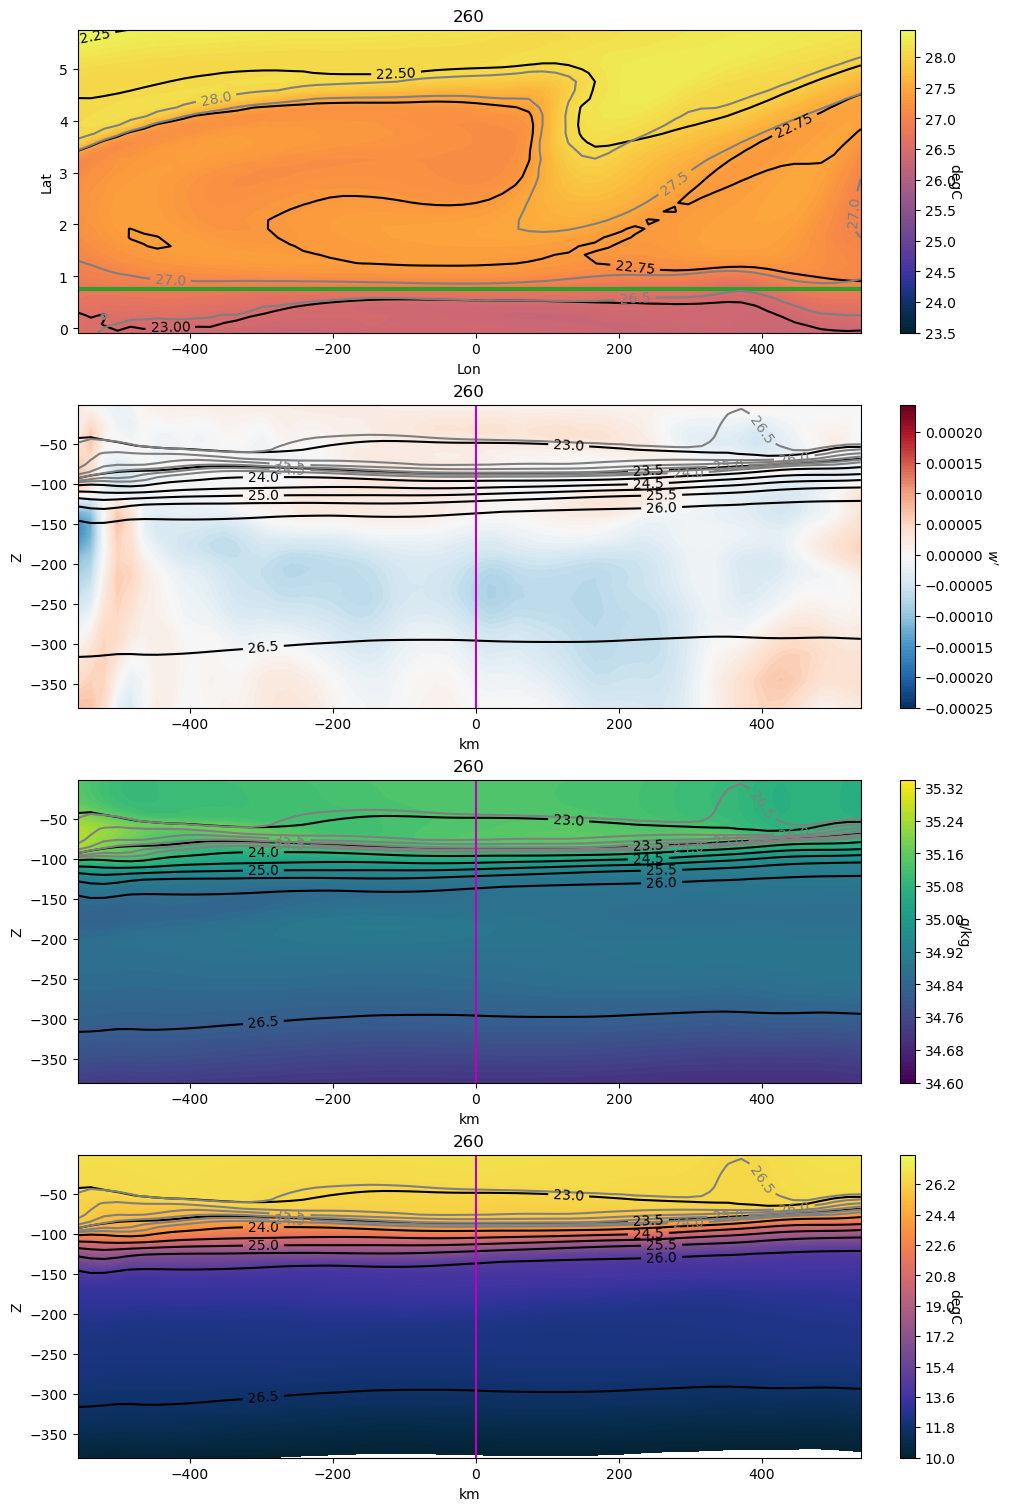

In [99]:
import cmocean as cmo 

depth = -400
fig, ax = plt.subplots(figsize=(10,15),nrows=4,constrained_layout=True)
xax = dsState.lon.values
yax = dsState.z.sel(z=slice(0,depth)).values

pos0 = ax[0].contourf(dsState.lon,dsState.lat,dsState.THETA.sel(time=[260.0],z=0.0,method='nearest').squeeze(),cmap=cmo.cm.thermal,levels=np.arange(23.5,28.5,0.05))
ax[0].set_xlabel('Lon')
ax[0].set_ylabel('Lat')
ax[0].axhline(0.75,color='tab:green',linewidth=3.0)
cbar0 = fig.colorbar(pos0,ax=ax[0])
cbar0.set_label('degC', rotation=270)
sigma_plot0 = sigma_0.sel(time=[260.0],z=0.0,method='nearest').squeeze()
SL0 = ax[0].contour(dsState.lon,dsState.lat,sigma_plot0,levels=np.arange(20.0,24.0,0.25),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(SL0)
theta_plot0 = dsState.THETA.sel(time=[260.0],z=0.0,method='nearest').squeeze()
TL0 = ax[0].contour(dsState.lon,dsState.lat,theta_plot0,levels=np.arange(23.0,30.0,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
ax[0].clabel(TL0)

pos1 = ax[1].contourf(xax,yax,baroclinic_w_filt.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
ax[1].set_xlabel('km')
ax[1].set_ylabel('Z')
cbar1 = fig.colorbar(pos1,ax=ax[1])
cbar1.set_label('$w\'$', rotation=270)
sigma_plot1 = sigma_0.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
SL1 = ax[1].contour(xax,yax,sigma_plot1,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(SL1)
theta_plot1 = dsState.THETA.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
TL1 = ax[1].contour(xax,yax,theta_plot1,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
ax[1].clabel(TL1)
# ax[0].axvline(-200,color='m')

# add contours of phi
pos2 = ax[2].contourf(xax,yax,dsState.SALT.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze(),cmap='viridis',levels=np.arange(34.6,35.35,0.01))
ax[2].set_xlabel('km')
ax[2].set_ylabel('Z')
cbar2 = fig.colorbar(pos2,ax=ax[2])
cbar2.set_label('g/kg', rotation=270)
sigma_plot2 = sigma_0.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
SL2 = ax[2].contour(xax,yax,sigma_plot2,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(SL2)
theta_plot2 = dsState.THETA.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
TL2 = ax[2].contour(xax,yax,theta_plot2,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
ax[2].clabel(TL2)
# ax[1].axvline(-200,color='m')

# add wind vectors and vertical shear contours
pos3 = ax[3].contourf(xax,yax,dsState.THETA.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze(),cmap=cmo.cm.thermal,levels=np.arange(10.0,28,0.05))
ax[3].set_xlabel('km')
ax[3].set_ylabel('Z')
cbar3 = fig.colorbar(pos3,ax=ax[3])
cbar3.set_label('degC', rotation=270)
sigma_plot3 = sigma_0.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
SL3 = ax[3].contour(xax,yax,sigma_plot3,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
ax[3].clabel(SL3)
theta_plot3 = dsState.THETA.sel(time=[260.0],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
TL3 = ax[3].contour(xax,yax,sigma_plot3,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
ax[3].clabel(TL3)
# ax[2].axvline(-200,color='m')

startDay = 260

def update(frame):

    day = frame + startDay

    ax[0].clear()
    pos0 = ax[0].contourf(dsState.lon,dsState.lat,dsState.THETA.sel(time=[day],z=0.0,method='nearest').squeeze(),cmap=cmo.cm.thermal,levels=np.arange(23.5,28.5,0.05))
    ax[0].set_xlabel('Lon')
    ax[0].set_ylabel('Lat')
    ax[0].axhline(0.75,color='tab:green',linewidth=3.0)
    sigma_plot0 = sigma_0.sel(time=[day],z=0.0,method='nearest').squeeze()
    SL0 = ax[0].contour(dsState.lon,dsState.lat,sigma_plot0,levels=np.arange(20.0,24.0,0.25),colors='k',linewidths=1.5, kwargs=dict(inline=True))
    ax[0].clabel(SL0)
    theta_plot0 = dsState.THETA.sel(time=[day],z=0.0,method='nearest').squeeze()
    TL0 = ax[0].contour(dsState.lon,dsState.lat,theta_plot0,levels=np.arange(23.0,30.0,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
    ax[0].clabel(TL0)
    ax[0].set_title(str(day))

    ax[1].clear()
    pos1 = ax[1].contourf(xax,yax,baroclinic_w_filt.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze(),cmap='RdBu_r',levels=np.arange(-0.00025,0.00025,0.000005))
    sigma_plot1 = sigma_0.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
    SL1 = ax[1].contour(xax,yax,sigma_plot1,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
    ax[1].clabel(SL1)
    ax[1].set_xlabel('km')
    ax[1].set_ylabel('Z')
    theta_plot1 = dsState.THETA.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
    TL1 = ax[1].contour(xax,yax,theta_plot1,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
    ax[1].clabel(TL1)
    ax[1].axvline(0,color='m')    
    ax[1].set_title(str(day))

    ax[2].clear()
    pos2 = ax[2].contourf(xax,yax,dsState.SALT.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze(),cmap='viridis',levels=np.arange(34.6,35.35,0.01))
    sigma_plot2 = sigma_0.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
    SL2 = ax[2].contour(xax,yax,sigma_plot2,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
    ax[2].clabel(SL2)
    ax[2].set_xlabel('km')
    ax[2].set_ylabel('Z')
    theta_plot2 = dsState.THETA.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
    TL2 = ax[2].contour(xax,yax,theta_plot2,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
    ax[2].clabel(TL2)
    ax[2].axvline(0,color='m')
    ax[2].set_title(str(day))

    ax[3].clear()
    pos3 = ax[3].contourf(xax,yax,dsState.THETA.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze(),cmap=cmo.cm.thermal,levels=np.arange(10.0,28,0.05))
    sigma_plot3 = sigma_0.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
    SL3 = ax[3].contour(xax,yax,sigma_plot3,levels=np.arange(23.0,28.5,0.5),colors='k',linewidths=1.5, kwargs=dict(inline=True))
    ax[3].clabel(SL3)
    ax[3].set_xlabel('km')
    ax[3].set_ylabel('Z')
    theta_plot3 = dsState.THETA.sel(time=[day],lat=[0.75],method='nearest').sel(z=slice(0,depth)).squeeze()
    TL3 = ax[3].contour(xax,yax,theta_plot3,levels=np.arange(24.0,28.5,0.5),colors='tab:gray',linewidths=1.5, kwargs=dict(inline=True))
    ax[3].clabel(TL3)
    ax[3].axvline(0,color='m')    
    ax[3].set_title(str(day))

    return (pos0,pos1,pos2,pos3)

video = animation.FuncAnimation(fig=fig, func=update, frames=len(range(280,366)),interval=500)
videostr = "Leewave_SALT_THETA_SST.mp4"
video.save(filename=videostr, writer="ffmpeg")

In [ ]:
# rotation, atan2(vanom,uanom) where v and u anomaly is the anomaly at each depth from the mean velocity profile 